In [700]:
import pandas as pd
import numpy as np

pred = pd.read_csv('data/presidential_data.csv')
covid = pd.read_csv('data/covid_data.csv')
other = pd.read_csv('data/other_data.csv')

In [701]:
# unify the column names
pred = pred[['State', 'county', 'candidate', 'party', 'votes', 'won', 'total_votes', 'percent']]
pred.county = [' '.join(x.split()[:-1])
               if (x.split()[-1]=='county' or  x.split()[-1]=='County') else x for x in pred.county]
pred.columns = ['State', 'County Name', 'candidate', 'party', 'votes', 'won', 'total_votes', 'percent']

covid = covid[['State', 'County Name', 'population'] + list(covid.columns[3:-1])]
covid.columns = ['State', 'County Name', 'population'] + ['case' + str(i+1) for i in range(10)] +['death' + str(i+1) for i in range(10)]
covid['County Name'] = [' '.join(x.split()[:-1])
               if (x.split()[-1]=='county' or  x.split()[-1]=='County') else x for x in covid['County Name']]  
    
other = other.drop('Unnamed: 0', axis = 1)
other.Area_name = [' '.join(x.split()[:-1])
               if (x.split()[-1]=='county' or  x.split()[-1]=='County') else x for x in other.Area_name]
other.columns = ['State', 'County Name', 'labor_force_2019', 'employed', 'unemployed',
                'rate', 'median_household_income_2018', 'less_than_high_school_2014_18',
                'high_school', 'college', 'bachelor_or_higher', 'percent_less_than_high_school',
                'percent_high_school', 'percent_college', 'percent_bachelor_or_higher','poverty']

    

In [702]:
# merge the data
df = pred.merge(covid, on=['State','County Name'])
df = df.merge(other,on=['State','County Name'] )

In [703]:
# add total covid data
df['total_cases'] =  df['case10']
df['total_deaths'] = df['death10']
df['death_rate'] = df.total_deaths/(df.total_cases + 0.0001)
df['total_cases_per1000'] =1000*df.total_cases/df.population
df['total_deaths_per1000'] =1000*df.total_deaths/df.population


In [704]:
da = pd.read_csv('LND01.csv') # merging additional data
da.columns = ['name', 'area']
da['State'] = [x.split(',')[1] if len(x.split(','))>1 else '' for x in da.name]
da['County Name'] = [x.split(',')[0] for x in da.name]
da['State'] = [x.strip() for x in da.State]
da['County Name'] = [x.strip() for x in da['County Name']]

In [705]:
da = da[['State','County Name', 'area']] # compute population density
df = df.merge(da, on=['State','County Name'])
df['density'] = df.population/df.area
df = df.drop(df.loc[(df.State == 'VA') & (df['County Name'] == 'Fairfax'),].index)

In [706]:
db = pd.read_csv('data/race_clean.csv')
df = df.merge(db, on = ['State','County Name'])
df.percent = df.percent*100
df.white_total = df.white_total*100
df.black_total = df.black_total*100
df.his_total = df.his_total*100
df.asian_total = df.asian_total*100

In [707]:
df.death_rate = df.death_rate*100

In [765]:
df['edu'] = np.zeros(df.shape[0])
df.edu.loc[df.low_edu < 17] = 1

In [771]:
df.low_edu.median()

24.0

In [708]:
df['urban'] = np.zeros(df.shape[0])
df.urban.loc[df.density>=500] = 1
df.urban.mean()

0.07082748948106592

In [709]:
df['income'] = np.zeros(df.shape[0])
df.income.loc[df.median_household_income_2018>=df.median_household_income_2018.median()] = 1
df.income.mean()

0.5

In [710]:
df.population = df.population/1000000

In [766]:
# fit a base model 
df['logpop'] = np.log(df.population)
df['Y'] = [1 if i else 0 for i in df.won]
df['log_deaths_per1000'] = np.log(df['total_deaths_per1000'] + 0.0001)
df['log_cases_per1000'] = np.log(df['total_cases_per1000'] + 0.0001)
df['low_edu'] = df['percent_less_than_high_school'] + df['percent_high_school']
df.to_csv('data/merged.csv')
import statsmodels.api as sm
import statsmodels.formula.api as smf

m = smf.ols(formula = 
           'percent ~ State + rate + median_household_income_2018 + low_edu +   total_cases_per1000 + total_cases_per1000:edu + + population + density + white_total + his_total + black_total',
          data = df).fit()
print(m.summary()) 

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     153.6
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:12:42   Log-Likelihood:                -9817.3
No. Observations:                2852   AIC:                         1.975e+04
Df Residuals:                    2794   BIC:                         2.010e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

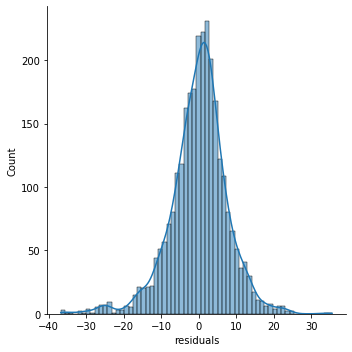

In [638]:
# residual plot
import seaborn as sns
resids = df.percent - m.predict()
resids.name = 'residuals'
sns.displot(resids, kde=True)

In [767]:
m2 = smf.ols(formula = 
           'percent ~ State + rate + median_household_income_2018 + low_edu +  density + total_cases_per1000  + population  + white_total + his_total + black_total',
          data = df).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     154.8
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        22:07:55   Log-Likelihood:                -9828.1
No. Observations:                2852   AIC:                         1.977e+04
Df Residuals:                    2795   BIC:                         2.011e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [714]:
m2 = smf.ols(formula = 
           'percent ~ State + rate + median_household_income_2018 + low_edu +  density + total_cases_per1000 + death_rate + population  + white_total + his_total + black_total',
          data = df).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     152.2
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:46:05   Log-Likelihood:                -9827.2
No. Observations:                2852   AIC:                         1.977e+04
Df Residuals:                    2794   BIC:                         2.012e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [768]:
df.rate

0       4.2
1       3.8
2       2.9
3       3.1
4       3.9
       ... 
2847    3.0
2848    2.9
2849    3.2
2850    3.5
2851    3.0
Name: rate, Length: 2852, dtype: float64

In [715]:
m3 = smf.ols(formula = 
           'percent ~ State + rate + median_household_income_2018 + low_edu +  density + total_cases_per1000:urban + total_cases_per1000 +population  + white_total + his_total + black_total',
          data = df).fit()
print(m3.summary())

                            OLS Regression Results                            
Dep. Variable:                percent   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        03:46:12   Log-Likelihood:                -9820.4
No. Observations:                2852   AIC:                         1.976e+04
Df Residuals:                    2794   BIC:                         2.010e+04
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [760]:
# summary statistics
df.groupby('won').aggregate({'death_rate':np.median, 'total_cases_per1000':np.median,
                            'density':np.median, 'low_edu': np.median, 'rate':np.median,
                            'poverty':np.median, 'white_total':np.median, 'black_total':np.median,
                            'his_total':np.median, 'population':np.median, 'won':'count',
                            'median_household_income_2018':np.median, 'total_deaths_per1000':np.median})

,death_rate,total_cases_per1000,density,low_edu,rate,poverty,white_total,black_total,his_total,population,won,median_household_income_2018,total_deaths_per1000
won,,,,,,,,,,,,,
False,2.089269,26.185041,157.949370,21.0,3.8,14.3,79.346182,8.963665,5.604982,0.128990,431,56168.0,0.542913
True,1.472557,24.859717,38.937315,24.6,3.6,14.0,94.156090,1.695872,2.960507,0.022195,2421,49991.0,0.366122


In [758]:
from scipy.stats import median_test
median_test(df.total_cases_per1000[df.won==True], df.total_cases_per1000[df.won==False])[1]

0.20957711593649506

In [193]:
# bootstrapping (stratefied)
import sklearn 
dt = df[['rate', 'median_household_income_2018', 
       'low_edu', 'logpop', 'log_cases_per1000',
       'death_rate','poverty','State','percent','total_votes']]

In [194]:
dm = {"AL": 9, "AK": 3, "AZ": 11, "AR": 6, "CA": 55,
        "CO": 9, "CT": 7, "DE": 3, "DC": 3,
        "FL": 29, "GA": 16, "HI": 4, "ID": 4, "IL": 20, "IN": 11,
        "IA": 6, "KS": 6, "KY": 8, "LA": 8, "ME": 4, "MD": 10,
        "MA": 11, "MI": 16, "MN": 10, "MS": 6, "MO": 10,
        "MT": 3, "NE": 5, "NV": 6, "NH": 4 , "NJ": 14,
        "NM": 5, "NY": 29, "NC": 15, "ND": 3, "OH": 18,
        "OK": 7, "OR": 7, "PA": 20, "PR": 0, "RI": 4,
        "SC": 9, "SD": 3, "TN": 11, "TX": 38, "UT": 6,
        "VT": 3, "VA": 13, "WA": 12, "WV": 5, "WI": 10,
        "WY": 3}

In [197]:
deaths = np.quantile(df.death_rate, 0.25)
cases = np.quantile(df.log_cases_per1000, 0.25)

In [261]:
def bootstrap(data, cases, deaths,dm):
    samples = sklearn.utils.resample(data, stratify = data.State) # sample the data
    m = smf.ols(formula = 
           'percent ~ rate + median_household_income_2018 + low_edu + logpop + log_cases_per1000 + death_rate + poverty + State',
          data = samples).fit() # fit the model
    dt_new = dt[['rate','median_household_income_2018','low_edu','logpop','poverty','State','total_votes']] 
    dt_new['log_cases_per1000'] = np.repeat(cases, samples.shape[0])
    dt_new['death_rate'] = np.repeat(deaths, samples.shape[0])
    predictions = m.predict(dt_new) # prediction with new data set
    for i in range(samples.shape[0]):
        if predictions[i]>1:
            predictions[i] = 1
        elif predictions[i]<0:
            predictions[i] = 0
        else:
            continue
    da = pd.DataFrame({'predictions': predictions, 'State':dt_new.State, 'total_votes':dt_new.total_votes})
    da['votes'] = da.predictions*da.total_votes
    groupings = da.groupby('State').aggregate({'votes':np.sum, 'total_votes':np.sum})
    groupings.columns = ['votes', 'total_votes']
    groupings.percent = groupings.votes/groupings.total_votes
    
    elec = 0
    for i in range(groupings.shape[0]):
        if groupings.percent[i]>=0.5:
            elec += dm[groupings.index[i]]
    return elec


In [264]:
import warnings
warnings.filterwarnings("ignore")
B = 5000
elec = [0]*B
for i in range(B):
    elec[i] = bootstrap(df, cases, deaths, dm)

315.4252 282.0 343.0


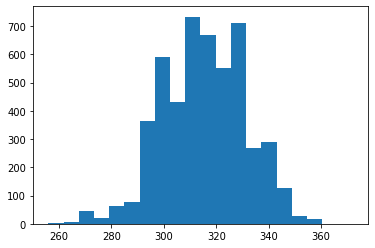

In [279]:
import matplotlib.pyplot as plt
plt.hist(elec, bins = 20)
avg = np.mean(elec)
lower = np.quantile(elec, 0.025)
upper = np.quantile(elec, 0.975)
print(avg, lower, upper)

In [296]:
deaths2 = np.quantile(df.death_rate, 0.9)
cases2 = np.quantile(df.log_cases_per1000, 0.9)
B = 5000
elec2 = [0]*B
for i in range(B):
    elec2[i] = bootstrap(df, cases2, deaths2, dm)

256.6028 241.0 276.0


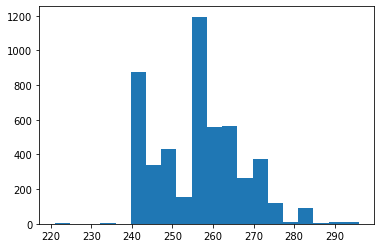

In [298]:
plt.hist(elec2, bins = 20)
avg = np.mean(elec2)
lower = np.quantile(elec2, 0.025)
upper = np.quantile(elec2, 0.975)
print(avg, lower, upper)

In [ ]:
# how often each state trump will win ?? for each bootstrapping calculate this

In [306]:
by_state = df.groupby('State').aggregate({'total_cases':np.sum, 'total_deaths':np.sum, 'population':np.sum})
by_state['rate'] = by_state.total_deaths/by_state.total_cases

In [308]:
np.corrcoef(by_state.rate, by_state.population)

array([[1.        , 0.14348071],
       [0.14348071, 1.        ]])

In [661]:
 (1493383/66650000)*1000

22.406346586646663

In [670]:
df.total_cases_per1000

0       18.425099
1       32.097342
2       35.131931
3       57.685724
4       36.913654
          ...    
2847     1.530288
2848     1.458312
2849     2.820093
2850     1.018423
2851     7.693231
Name: total_cases_per1000, Length: 2852, dtype: float64

In [716]:
df.total_cases.sum()/(df.population.sum()*1000000)*1000

27.28552664127732

In [759]:
df.population.sum()

275.303354